# Notebook 6: Gated vs No-gate + Generalization Evaluation

This notebook:
1. Trains gated vs no-gate for 50 generations on ppt_train
2. Tracks program-choice entropy (rsa_program) and lexeme-mapping entropy
3. Freezes final state and evaluates on ppt_test (unseen participant)
4. Compares gen0 vs gen50 (gated/no-gate) on the test set
5. Prints traces for selected generations

In [6]:
import os
import sys
import random
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if os.path.basename(os.getcwd()) == "notebooks_new":
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
else:
    ROOT_DIR = os.path.abspath(os.getcwd())
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from model.transmission.transmission_chain import run_comm_chain_bayes_rsa

In [23]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

SHOW_PLOTS = True
OUT_DIR = os.path.join(ROOT_DIR, "results", "comm")
os.makedirs(OUT_DIR, exist_ok=True)

PPT_TRAIN = 1
SOURCE_SUBDIR = "programs_for_you"
LEXEMES = ["blah", "blab", "bloop", "bleep", "floop"]

N_GEN = 50
SPEAKER_MODE = "rsa_program"

SPEAKER_ALPHA_PROG = 2.0
SPEAKER_ALPHA_UTT = 2.0
SPEAKER_BETA_COST = 0.30
EPSILON = 0.01

GATED_PARAMS = {
    "min_attempts": 5,
    "min_success_rate": 0.4,
    "p_innovate": 0.10,
    "pre_promote_chunk_correct": 0.60,
    "max_promote_per_gen": 1,
}

NOGATE_PARAMS = {
    "min_attempts": 0,
    "min_success_rate": 0.0,
    "p_innovate": 1.0,
    "pre_promote_chunk_correct": 1.0,
    "max_promote_per_gen": 99,
}

USE_PARALLEL = True

# Generalization test
TEST_PPT_IDS = list(range(2, 11))
TEST_NUM_REPEATS = 3
TEST_MAX_WORKERS = 6



In [8]:
def train_model(params, label):
    df, traces, final_state = run_comm_chain_bayes_rsa(
        ppt_id=PPT_TRAIN,
        data_model_dir=os.path.join(ROOT_DIR, "data", "model"),
        num_generations=N_GEN,
        lexemes=LEXEMES,
        speaker_mode=SPEAKER_MODE,
        min_attempts=params["min_attempts"],
        min_success_rate=params["min_success_rate"],
        p_innovate=params["p_innovate"],
        pre_promote_chunk_correct=params["pre_promote_chunk_correct"],
        max_promote_per_gen=params["max_promote_per_gen"],
        speaker_alpha_prog=SPEAKER_ALPHA_PROG,
        speaker_alpha_utt=SPEAKER_ALPHA_UTT,
        speaker_beta_cost=SPEAKER_BETA_COST,
        epsilon=EPSILON,
        random_seed=SEED,
        source_subdir=SOURCE_SUBDIR,
        trace_gens=TRACE_GENS,
        return_traces=True,
        return_final_state=True,
    )
    df["model"] = label
    return df, traces, final_state



In [9]:
if USE_PARALLEL:
    with ThreadPoolExecutor(max_workers=2) as pool:
        fut_g = pool.submit(train_model, GATED_PARAMS, "gated")
        fut_n = pool.submit(train_model, NOGATE_PARAMS, "nogate")
        gated_df, gated_traces, gated_state = fut_g.result()
        nogate_df, nogate_traces, nogate_state = fut_n.result()
else:
    gated_df, gated_traces, gated_state = train_model(GATED_PARAMS, "gated")
    nogate_df, nogate_traces, nogate_state = train_model(NOGATE_PARAMS, "nogate")

In [10]:
print(
    f"  gated  final acc_comm={gated_df['acc_comm'].iloc[-1]:.3f}, "
    f"msg_len={gated_df['msg_len'].iloc[-1]:.2f}, "
    f"num_active_chunks={gated_df['num_active_chunks'].iloc[-1]:.0f}"
)
print(
    f"  nogate final acc_comm={nogate_df['acc_comm'].iloc[-1]:.3f}, "
    f"msg_len={nogate_df['msg_len'].iloc[-1]:.2f}, "
    f"num_active_chunks={nogate_df['num_active_chunks'].iloc[-1]:.0f}"
)

  gated  final acc_comm=0.725, msg_len=6.67, num_active_chunks=4
  nogate final acc_comm=0.844, msg_len=7.50, num_active_chunks=4


In [11]:
train_df = pd.concat([gated_df, nogate_df], ignore_index=True)

train_df

,generation,acc_comm,msg_len,frag_rate,active_chunk_rate,program_level,program_choice_entropy,lexeme_mapping_entropy,ppt_id,speaker_mode,num_active_chunks,max_candidate_attempts,max_candidate_success_rate,num_chunks_used,num_new_chunks_used,reuse_chunk_rate,chunks_used,num_promoted_this_gen,model
0,0.0,0.746753,12.833333,0.012987,0.0,0.166667,0.048915,1.560338,1.0,rsa_program,0.0,1.0,1.0,2.0,2.0,0.0,chunk_C|chunk_L,0.0,gated
1,1.0,0.703226,12.916667,0.019355,0.0,0.166667,0.070075,1.473295,1.0,rsa_program,0.0,3.0,1.0,1.0,1.0,0.0,chunk_8b,0.0,gated
2,2.0,0.762195,13.666667,0.000000,0.0,0.000000,0.000000,1.453717,1.0,rsa_program,0.0,3.0,1.0,0.0,0.0,0.0,,0.0,gated
3,3.0,0.792453,13.250000,0.006289,0.0,0.083333,0.016153,1.453717,1.0,rsa_program,0.0,3.0,1.0,1.0,0.0,1.0,chunk_C,0.0,gated
4,4.0,0.731707,13.666667,0.000000,0.0,0.000000,0.000000,1.449510,1.0,rsa_program,0.0,3.0,1.0,0.0,0.0,0.0,,0.0,gated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45.0,0.850000,6.666667,0.212500,1.0,0.750000,0.238528,1.394037,1.0,rsa_program,4.0,5.0,0.0,4.0,0.0,1.0,chunk_8b|chunk_C|chunk_L|chunk_Pi,0.0,nogate
96,46.0,0.784091,7.333333,0.170455,1.0,0.628788,0.238528,1.394037,1.0,rsa_program,4.0,5.0,0.0,4.0,0.0,1.0,chunk_8b|chunk_C|chunk_L|chunk_Pi,0.0,nogate
97,47.0,0.788889,7.500000,0.166667,1.0,0.674242,0.238528,1.394037,1.0,rsa_program,4.0,5.0,0.0,4.0,0.0,1.0,chunk_8b|chunk_C|chunk_L|chunk_Pi,0.0,nogate
98,48.0,0.705882,7.083333,0.188235,1.0,0.712121,0.238528,1.394037,1.0,rsa_program,4.0,5.0,0.0,4.0,0.0,1.0,chunk_8b|chunk_C|chunk_L|chunk_Pi,0.0,nogate


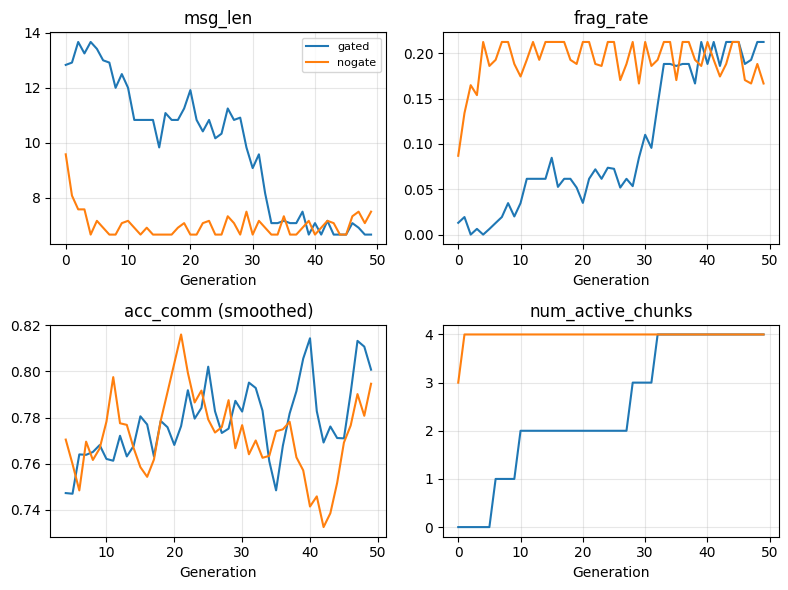

In [12]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    for model_label, sub_df in [("gated", gated_df), ("nogate", nogate_df)]:
        axes[0, 0].plot(sub_df["generation"], sub_df["msg_len"], label=model_label)
        axes[0, 1].plot(sub_df["generation"], sub_df["frag_rate"], label=model_label)
        axes[1, 0].plot(sub_df["generation"], pd.Series(list(sub_df["acc_comm"])).rolling(window=5).mean(), label=model_label)
        axes[1, 1].plot(sub_df["generation"], sub_df["num_active_chunks"], label=model_label)
    axes[0, 0].set_title("msg_len")
    axes[0, 1].set_title("frag_rate")
    axes[1, 0].set_title("acc_comm (smoothed)")
    axes[1, 1].set_title("num_active_chunks")
    for ax in axes.flat:
        ax.set_xlabel("Generation")
        ax.grid(alpha=0.3)
    axes[0, 0].legend(fontsize=8)
    plt.tight_layout()
    plt.show()



`program_level`

For each trial there are multiple equivalent program representations with lengths $L$. If the speaker chooses a representation of length $L_{\text{chosen}}$, $\text{program\_level}=\frac{L_{\max}-L_{\text{chosen}}}{\max(1,\;L_{\max}-L_{\min})}.$

So $0$ means the speaker used the most expanded/primitive form, and $1$ means the most compressed/chunked form available for that trial.

`program_choice_entropy`

When the speaker forms a softmax over candidate programs $p \in \mathcal{P}$: $P(p)=\mathrm{softmax}(\alpha_{\text{prog}}\,U(p)).$

Measure of confidence entropy $H=-\sum_{p\in\mathcal{P}} P(p)\log P(p).$

`lexeme_mapping_entropy`

Just as above, $H=-\sum_a P(a\mid u)\log P(a\mid u),$
and average over utterances (and across speaker/listener posteriors). Lower means more confident, sharper conventions.

`reuse_chunk_rate`

Within a generation, let $C_{\text{used}}$ be the set of chunk actually used in produced programs, and $C_{\text{seen}}$ used in any previous generation. Then $
\text{reuse\_chunk\_rate}=\frac{|C_{\text{used}}\cap C_{\text{seen}}|}{\max(1,\;|C_{\text{used}}|)}.$



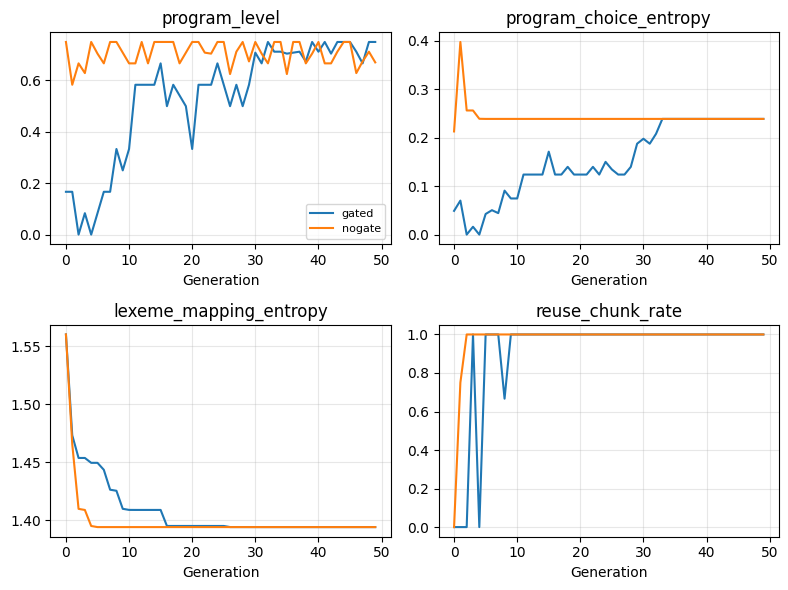

In [22]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    for model_label, sub_df in [("gated", gated_df), ("nogate", nogate_df)]:
        axes[0, 0].plot(sub_df["generation"], sub_df["program_level"], label=model_label)
        axes[0, 1].plot(sub_df["generation"], sub_df["program_choice_entropy"], label=model_label)
        axes[1, 0].plot(sub_df["generation"], pd.Series(list(sub_df["lexeme_mapping_entropy"])), label=model_label)
        axes[1, 1].plot(sub_df["generation"], sub_df["reuse_chunk_rate"], label=model_label)
    
    axes[0, 0].set_title("program_level")
    axes[0, 1].set_title("program_choice_entropy")
    axes[1, 0].set_title("lexeme_mapping_entropy")
    axes[1, 1].set_title("reuse_chunk_rate")

    for ax in axes.flat:
        ax.set_xlabel("Generation")
        ax.grid(alpha=0.3)
    axes[0, 0].legend(fontsize=8)
    plt.tight_layout()
    plt.show()



In [25]:
def eval_on_test(label, ppt_id, seed, arch_prior, build_prior, active_chunks):
    df = run_comm_chain_bayes_rsa(
        ppt_id=int(ppt_id),
        data_model_dir=os.path.join(ROOT_DIR, "data", "model"),
        num_generations=1,
        lexemes=LEXEMES,
        speaker_mode=SPEAKER_MODE,
        min_attempts=0,
        min_success_rate=0.0,
        p_innovate=0.0,
        pre_promote_chunk_correct=1.0,
        max_promote_per_gen=0,
        speaker_alpha_prog=SPEAKER_ALPHA_PROG,
        speaker_alpha_utt=SPEAKER_ALPHA_UTT,
        speaker_beta_cost=SPEAKER_BETA_COST,
        epsilon=EPSILON,
        random_seed=int(seed),
        source_subdir=SOURCE_SUBDIR,
        init_arch_prior=arch_prior,
        init_build_prior=build_prior,
        init_active_chunks=active_chunks,
        freeze_updates=True,
    )
    return {
        "label": label,
        "ppt_id": int(ppt_id),
        "seed": int(seed),
        "acc_comm": float(df["acc_comm"].iloc[0]),
        "msg_len": float(df["msg_len"].iloc[0]),
        "frag_rate": float(df["frag_rate"].iloc[0]),
        "program_choice_entropy": float(df["program_choice_entropy"].iloc[0]),
        "lexeme_mapping_entropy": float(df["lexeme_mapping_entropy"].iloc[0]),
    }

In [28]:
jobs = []
for ppt_id in TEST_PPT_IDS:
    for rep in range(int(TEST_NUM_REPEATS)):
        seed = int(SEED + 1000 + 17 * int(ppt_id) + rep)
        jobs.append(("gen0_untrained", ppt_id, seed, None, None, None))
        jobs.append(("gen50_gated", ppt_id, seed, gated_state["arch_prior"], gated_state["build_prior"], gated_state["active_chunks"]))
        jobs.append(("gen50_nogate", ppt_id, seed, nogate_state["arch_prior"], nogate_state["build_prior"], nogate_state["active_chunks"]))

if TEST_MAX_WORKERS <= 1:
    results = [eval_on_test(*j) for j in jobs]
else:
    with ThreadPoolExecutor(max_workers=int(TEST_MAX_WORKERS)) as pool:
        results = list(pool.map(lambda j: eval_on_test(*j), jobs))

In [38]:
gen_runs = pd.DataFrame(results)

In [34]:
summary_cols = ["acc_comm", "msg_len", "frag_rate", "program_choice_entropy", "lexeme_mapping_entropy"]
gen_summary = (
    gen_runs.groupby("label")[summary_cols]
    .agg(["mean", "std", "min", "max"])
    .reset_index()
)
gen_summary

label  acc_comm                                  msg_len           \
                       mean       std       min       max       mean      std   
0  gen0_untrained  0.782520  0.023064  0.731707  0.829268  13.666667  0.00000   
1     gen50_gated  0.781989  0.026845  0.734940  0.835294   7.126543  0.35534   
2    gen50_nogate  0.781989  0.026845  0.734940  0.835294   7.126543  0.35534   

                        frag_rate                                \
         min        max      mean       std       min       max   
0  13.666667  13.666667   0.00000  0.000000  0.000000  0.000000   
1   6.500000   7.750000   0.18455  0.019311  0.150538  0.217949   
2   6.500000   7.750000   0.18455  0.019311  0.150538  0.217949   

  program_choice_entropy                               lexeme_mapping_entropy  \
                    mean       std       min       max                   mean   
0               0.000000  0.000000  0.000000  0.000000               1.560338   
1               0.228965  0.022344  0.204502  0.278233               1.394037   
2               0.228965  0.022344  0.204502  0.278233               1.394037   

                            
   std       min       max  
0  0.0  1.560338  1.560338  
1  0.0  1.394037  1.394037  
2  0.0  1.394037  1.394037

In [32]:
def print_trace(trace_df, max_trials=2, max_steps=30):
    if trace_df is None or len(trace_df) == 0:
        print("  (no trace data)")
        return
    trials = sorted(list(set(int(x) for x in trace_df["trial"].tolist())))
    for t in trials[:max_trials]:
        sub = trace_df[trace_df["trial"] == t].copy()
        if len(sub) == 0:
            continue
        prog = str(list(sub["target_program"])[0])
        print(f"  trial={t} target_program={prog}")
        for i, (_, r) in enumerate(sub.iterrows()):
            if i >= max_steps:
                print("    ... truncated ...")
                break
            intent = str(r["intention"])
            utt = str(r["utterance"])
            resp = str(r["response"])
            mark = "*" if intent == resp else " "
            print(f"    {mark} {intent} | utt={utt} | resp={resp}")

In [36]:
for g in [49]:
    print(f"Generation {g}:")
    if g in gated_traces:
        print("\n GATED TRACES ")
        print_trace(gated_traces[g])
    if g in nogate_traces:
        print("\n NO-GATE TRACES ")
        print_trace(nogate_traces[g])

Generation 49:

 GATED TRACES 
  trial=1 target_program=h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h
      h | utt=place a horizontal block. | resp=r_9
    * l_4 | utt=move to the left by 4 | resp=l_4
    * h | utt=place a horizontal block. | resp=h
    * l_1 | utt=move to the left by 1 | resp=l_1
    * v | utt=place a vertical block. | resp=v
      v | utt=place a vertical block. | resp=l_10
      r_9 | utt=move to the right by 9 | resp=r_5
      v | utt=place a vertical block. | resp=l_11
    * r_6 | utt=move to the right by 6 | resp=r_6
    * v | utt=place a vertical block. | resp=v
    * l_5 | utt=move to the left by 5 | resp=l_5
    * h | utt=place a horizontal block. | resp=h
    * r_4 | utt=move to the right by 4 | resp=r_4
    * h | utt=place a horizontal block. | resp=h
  trial=2 target_program=h l_4 h l_1 v v r_12 h l_1 v v r_1 h
    * h | utt=place a horizontal block. | resp=h
      l_4 | utt=move to the left by 4 | resp=l_9
      h | utt=place a horizontal block. | resp=l_6
    